In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

In [3]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont

In [4]:
# class SimpleGameOfLifeEnv(gym.Env):
#     metadata = {
#         'render.modes': ['human', 'rgb_array'],
#         'video.frames_per_second': 1
#     }

#     STATE_ELEMENTS = 7
#     STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
#               'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", "tax_deposit", 
#               "tax_adv_deposit", "net_worth"]
#     STATE_AGE = 0
#     STATE_SALARY = 1
#     STATE_HOME_VALUE = 2
#     STATE_HOME_LOAN = 3
#     STATE_HOME_REQ_PAYMENT = 4
#     STATE_SAVE_TAX_ADV = 5
#     STATE_SAVE_TAXABLE = 6

#     MEG = 1.0e6

#     ACTION_ELEMENTS = 4
#     ACTION_HOME_LOAN = 0
#     ACTION_SAVE_TAX_ADV = 1
#     ACTION_SAVE_TAXABLE = 2
#     ACTION_LUXURY = 3

#     INFLATION = (0.015)/12.0
#     INTEREST = (0.05)/12.0
#     TAX_RATE = (.142)/12.0
#     EXPENSES = 0.6
#     INVEST_RETURN = 0.065/12.0
#     SALARY_LOW = 40000.0
#     SALARY_HIGH = 60000.0
#     START_AGE = 18
#     RETIRE_AGE = 80

#     def __init__(self, goal_velocity=0):
#         self.verbose = False
#         self.viewer = None

#         self.action_space = spaces.Box(
#           low=0.0,
#           high=1.0,
#           shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
#           dtype=np.float32
#         )
#         self.observation_space = spaces.Box(
#           low=0,
#           high=2,
#           shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
#           dtype=np.float32
#         )

#         self.seed()
#         self.reset()

#         self.state_log = []

#     def seed(self, seed=None):
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]

#     def _calc_net_worth(self):
#         home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
#         principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
#         worth = home_value - principal
#         worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
#         worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
#         return worth

#     def _eval_action(self, action, payment):
#         # Calculate actions
#         act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
#         act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
#         act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
#         act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
#         if payment <=0:
#             act_home_payment = 0
#         total_act = act_home_payment + act_tax_adv_pay + act_taxable + act_luxury + self.expenses

#         if total_act <1e-2:
#             pct_home_payment = 0
#             pct_tax_adv_pay = 0
#             pct_taxable = 0
#             pct_luxury = 0
#         else:
#             pct_home_payment = act_home_payment / total_act
#             pct_tax_adv_pay = act_tax_adv_pay / total_act
#             pct_taxable = act_taxable / total_act
#             pct_luxury = act_luxury / total_act

#         return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

#     def step(self, action):
#         self.last_action = action
#         age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
#         salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
#         home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
#         principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
#         payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
#         net1 = self._calc_net_worth()
#         remaining_salary = salary

#         # Calculate actions
#         pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
#             self._eval_action(action,payment)

#         # Expenses
#         current_expenses = salary * self.expenses
#         remaining_salary -= current_expenses
#         if self.verbose:
#             print(f"Expenses: {current_expenses}")
#             print(f"Remaining Salary: {remaining_salary}")

#         # Tax advantaged deposit action
#         my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
#         my_tax_adv_deposit = min(my_tax_adv_deposit, \
#             self.year_tax_adv_deposit_left) # Govt CAP
#         self.year_tax_adv_deposit_left -= my_tax_adv_deposit
#         remaining_salary -= my_tax_adv_deposit
#         tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
#         self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
#             int(tax_adv_deposit)

#         if self.verbose:
#             print(f"IRA Deposit: {tax_adv_deposit}")
#             print(f"Remaining Salary: {remaining_salary}")

#         # Tax
#         remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
#         if self.verbose:
#             print(f"Tax Salary: {remaining_salary}")

#         # Home payment
#         actual_payment = min(salary * pct_home_payment, remaining_salary)

#         if principal>0:
#             ipart = principal * SimpleGameOfLifeEnv.INTEREST
#             ppart = actual_payment - ipart
#             principal = int(principal-ppart)
#             if principal<=0:
#                 principal = 0
#                 self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
#             elif actual_payment < payment:
#                 self.late_count += 1
#                 if self.late_count>15:
#                     sell = (home_value-principal)/2
#                     sell -= 20000
#                     sell = max(sell,0)
#                     self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
#                     principal = 0
#                     home_value = 0
#                     self.expenses += .3
#                     self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
#                     if self.verbose:
#                         print(f"Foreclosure!!")
#                     else:
#                         late_fee = payment * 0.1
#                         principal += late_fee
#                     if self.verbose:
#                         print(f"Late Fee: {late_fee}")


#         self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
#         remaining_salary -= actual_payment

#         if self.verbose:
#             print(f"Home Payment: {actual_payment}")
#             print(f"Remaining Salary: {remaining_salary}")

#         # Taxable savings
#         actual_savings = remaining_salary * pct_taxable
#         self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
#         remaining_salary -= actual_savings

#         if self.verbose:
#             print(f"Tax Save: {actual_savings}")
#             print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

#         # Investment income
#         return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
#             self.invest_return
#         return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
#             self.invest_return

#         return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
#         self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
#         self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

#         # Yearly events
#         if age>0 and age % 12 == 0:
#             self.perform_yearly()

#         # Monthly events
#         self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
#         # Time to retire (by age?)
#         done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
#             (SimpleGameOfLifeEnv.RETIRE_AGE*12)

#         # Calculate reward 
#         net2 = self._calc_net_worth()
#         reward = net2 - net1

#         # Track progress
#         if self.verbose:
#             print(f"Networth: {nw}")
#             print(f"*** End Step {self.step_num}: State={self.state}, \
#                 Reward={reward}")
#         self.state_log.append(self.state + [current_expenses, actual_payment, 
#         actual_savings, my_tax_adv_deposit, net2])
#         self.step_num += 1

#         # Normalize state and finish up
#         norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
#         return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

#         def perform_yearly(self):
#             salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
#             home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]

#             self.inflation = SimpleGameOfLifeEnv.INTEREST + \
#               self.np_random.normal(loc=0,scale=1e-2)
#             self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
#               self.np_random.normal(loc=0,scale=1e-2)

#             self.year_tax_adv_deposit_left = 19000
#             self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
#             int(salary * (1+self.inflation))

#             self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
#             = int(home_value * (1+self.inflation))

#         def reset(self):
#             self.expenses = SimpleGameOfLifeEnv.EXPENSES
#             self.late_count = 0
#             self.step_num = 0
#             self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
#             self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
#             self.state_log = []
#             salary = float(self.np_random.randint(low=SimpleGameOfLifeEnv.SALARY_LOW,
#                                    high=SimpleGameOfLifeEnv.SALARY_HIGH))
#             house_mult = self.np_random.uniform(low=1.5,high=4)
#             value = round(salary*house_mult)
#             p = (value*0.9)
#             i = SimpleGameOfLifeEnv.INTEREST
#             n = 30 * 12
#             m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
#             self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
#             SimpleGameOfLifeEnv.START_AGE * 12
#             self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
#             self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
#             self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
#             self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
#             self.year_tax_adv_deposit_left = 19000
#             self.perform_yearly()
#             return np.array(self.state)

#         def render(self, mode='human'):
#             screen_width = 600
#             screen_height = 400

#             img = PIL.Image.new('RGB', (600, 400))
#             d = PIL.ImageDraw.Draw(img)
#             font = ImageFont.load_default()
#             y = 0
#             _, height = d.textsize("W", font)

#             age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
#             salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
#             home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
#             home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
#             home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
#             balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
#             balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
#             net_worth = self._calc_net_worth()

#             d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Home Value: {home_value:,}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Home Loan: {home_loan:,}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Home Payment: {home_payment:,}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
#                    fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
#                    fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
#             y+=height*2

#             payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
#             pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
#               self._eval_action(self.last_action,payment)
#             d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
#                    fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
#             y+=height
#             d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

#             return np.array(img)

#             def close(self):
#                 pass

In [5]:
class SimpleGameOfLifeEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    STATE_ELEMENTS = 7
    STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
              'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", "tax_deposit", 
              "tax_adv_deposit", "net_worth"]
    STATE_AGE = 0
    STATE_SALARY = 1
    STATE_HOME_VALUE = 2
    STATE_HOME_LOAN = 3
    STATE_HOME_REQ_PAYMENT = 4
    STATE_SAVE_TAX_ADV = 5
    STATE_SAVE_TAXABLE = 6

    MEG = 1.0e6

    ACTION_ELEMENTS = 4
    ACTION_HOME_LOAN = 0
    ACTION_SAVE_TAX_ADV = 1
    ACTION_SAVE_TAXABLE = 2
    ACTION_LUXURY = 3

    INFLATION = (0.015)/12.0
    INTEREST = (0.05)/12.0
    TAX_RATE = (.142)/12.0
    EXPENSES = 0.6
    INVEST_RETURN = 0.065/12.0
    SALARY_LOW = 40000.0
    SALARY_HIGH = 60000.0
    START_AGE = 18
    RETIRE_AGE = 80

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None

      self.action_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=0,
          high=2,
          shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
          dtype=np.float32
      )

      self.seed()
      self.reset()

      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _calc_net_worth(self):
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      worth = home_value - principal
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
      return worth

    def _eval_action(self, action, payment):
      # Calculate actions
      act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
      act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
      act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
      act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
      if payment <=0:
        act_home_payment = 0
      total_act = act_home_payment + act_tax_adv_pay + act_taxable + act_luxury + self.expenses

      if total_act <1e-2:
        pct_home_payment = 0
        pct_tax_adv_pay = 0
        pct_taxable = 0
        pct_luxury = 0
      else:
        pct_home_payment = act_home_payment / total_act
        pct_tax_adv_pay = act_tax_adv_pay / total_act
        pct_taxable = act_taxable / total_act
        pct_luxury = act_luxury / total_act

      return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

    def step(self, action):
      self.last_action = action
      age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
      net1 = self._calc_net_worth()
      remaining_salary = salary

      # Calculate actions
      pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
        self._eval_action(action,payment)

      # Expenses
      current_expenses = salary * self.expenses
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax advantaged deposit action
      my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
      my_tax_adv_deposit = min(my_tax_adv_deposit, \
        self.year_tax_adv_deposit_left) # Govt CAP
      self.year_tax_adv_deposit_left -= my_tax_adv_deposit
      remaining_salary -= my_tax_adv_deposit
      tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
        int(tax_adv_deposit)

      if self.verbose:
        print(f"IRA Deposit: {tax_adv_deposit}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax
      remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
      if self.verbose:
        print(f"Tax Salary: {remaining_salary}")

      # Home payment
      actual_payment = min(salary * pct_home_payment, remaining_salary)

      if principal>0:
        ipart = principal * SimpleGameOfLifeEnv.INTEREST
        ppart = actual_payment - ipart
        principal = int(principal-ppart)
        if principal<=0:
          principal = 0
          self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
        elif actual_payment < payment:
          self.late_count += 1
          if self.late_count>15:
            sell = (home_value-principal)/2
            sell -= 20000
            sell = max(sell,0)
            self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
            principal = 0
            home_value = 0
            self.expenses += .3
            self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
            if self.verbose:
              print(f"Foreclosure!!")
          else:
            late_fee = payment * 0.1
            principal += late_fee
            if self.verbose:
              print(f"Late Fee: {late_fee}")


        self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
        remaining_salary -= actual_payment

      if self.verbose:
        print(f"Home Payment: {actual_payment}")
        print(f"Remaining Salary: {remaining_salary}")

      # Taxable savings
      actual_savings = remaining_salary * pct_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings

      if self.verbose:
        print(f"Tax Save: {actual_savings}")
        print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

      # Investment income
      return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
          self.invest_return
      return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
          self.invest_return

      return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

      # Yearly events
      if age>0 and age % 12 == 0:
        self.perform_yearly()

      # Monthly events
      self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
      # Time to retire (by age?)
      done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
        (SimpleGameOfLifeEnv.RETIRE_AGE*12)

      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1

      # Track progress
      if self.verbose:
        print(f"Networth: {nw}")
        print(f"*** End Step {self.step_num}: State={self.state}, \
          Reward={reward}")
      self.state_log.append(self.state + [current_expenses, actual_payment, 
      actual_savings, my_tax_adv_deposit, net2])
      self.step_num += 1

      # Normalize state and finish up
      norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
      return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

    def perform_yearly(self):
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      
      self.inflation = SimpleGameOfLifeEnv.INTEREST + \
          self.np_random.normal(loc=0,scale=1e-2)
      self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
          self.np_random.normal(loc=0,scale=1e-2)

      self.year_tax_adv_deposit_left = 19000
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
        int(salary * (1+self.inflation))

      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
        = int(home_value * (1+self.inflation))

    def reset(self):
      self.expenses = SimpleGameOfLifeEnv.EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
      self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
      self.state_log = []
      salary = float(self.np_random.randint(low=SimpleGameOfLifeEnv.SALARY_LOW,
                               high=SimpleGameOfLifeEnv.SALARY_HIGH))
      house_mult = self.np_random.uniform(low=1.5,high=4)
      value = round(salary*house_mult)
      p = (value*0.9)
      i = SimpleGameOfLifeEnv.INTEREST
      n = 30 * 12
      m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
        SimpleGameOfLifeEnv.START_AGE * 12
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
      self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
      self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
      self.year_tax_adv_deposit_left = 19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)
  
        age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
        salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
        home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
        home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
        home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
        balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
        net_worth = self._calc_net_worth()

        d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Value: {home_value:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Loan: {home_loan:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Payment: {home_payment:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
        y+=height*2

        payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
          self._eval_action(self.last_action,payment)
        d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

        return np.array(img)

    def close(self):
        pass

In [6]:
register(
    id='simple-game-of-life-v0',
    entry_point=f'{__name__}:SimpleGameOfLifeEnv',
)

In [7]:
env_name = 'simple-game-of-life-v0'
env = gym.make(env_name)

env.reset()
done = False

i = 0
env.verbose = False
while not done:
    i += 1
    #if i>36: break
    # ACTION_HOME_LOAN = 0, ACTION_SAVE_TAX_ADV = 1, ACTION_SAVE_TAXABLE = 2
    # ACTION_LUXURY = 3
    state, reward, done, _ = env.step([1,1,0,0])
    env.render()
    
env.close()
print(env._calc_net_worth())

2686643.752598176


In [8]:
import pandas as pd

df = pd.DataFrame(env.state_log, columns=SimpleGameOfLifeEnv.STATES)
df = df.round(0)
df['age'] = df['age']/12
df['age'] = df['age'].round(2)
for col in df.columns:
  df[col] = df[col].apply(lambda x : "{:,}".format(x))

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 12)
display(df)

,age,salary,home_value,...,tax_deposit,tax_adv_deposit,net_worth
0,18.08,"3,941","100,175",...,0.0,"1,503.0","11,847.0"
1,18.17,"3,941","100,175",...,0.0,"1,516.0","13,084.0"
2,18.25,"3,941","100,175",...,0.0,"1,516.0","14,323.0"
3,18.33,"3,941","100,175",...,0.0,"1,516.0","15,565.0"
4,18.42,"3,941","100,175",...,0.0,"1,516.0","16,809.0"
...,...,...,...,...,...,...,...
740,79.75,"5,676","145,283",...,0.0,568.0,"2,785,885.0"
741,79.83,"5,676","145,283",...,0.0,568.0,"2,760,799.0"
742,79.92,"5,676","145,283",...,0.0,568.0,"2,735,957.0"
743,80.0,"5,676","145,283",...,0.0,568.0,"2,711,357.0"


In [9]:
# How long should training run?
num_iterations = 50000 
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 50
# How much data should we store for training examples.
replay_buffer_max_length = 100000

batch_size = 64  
#learning_rate = 1e-4 
# How often should the program provide an update.
log_interval = 2500  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 100
# How often should an evaluation occur.
eval_interval = 5000

Instanciate the Environment

In [10]:
env_name = 'simple-game-of-life-v0'
#env_name = 'MountainCarContinuous-v0'
env = suite_gym.load(env_name)

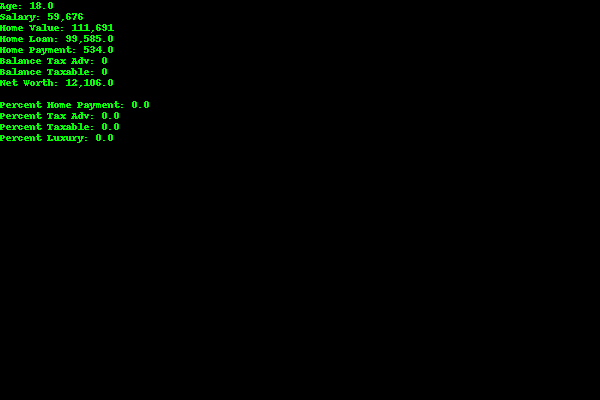

In [11]:
env.reset()
PIL.Image.fromarray(env.render())

In [12]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [13]:
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(400,)
critic_action_fc_layers=None
critic_joint_fc_layers=(300,)
ou_stddev=0.2
ou_damping=0.15
target_update_tau=0.05
target_update_period=5
dqda_clipping=None
td_errors_loss_fn=tf.compat.v1.losses.huber_loss
gamma=0.995
reward_scale_factor=1.0
gradient_clipping=None

actor_learning_rate=1e-4
critic_learning_rate=1e-3
debug_summaries=False
summarize_grads_and_vars=False

global_step = tf.compat.v1.train.get_or_create_global_step()

actor_net = actor_network.ActorNetwork(
        train_env.time_step_spec().observation,
        train_env.action_spec(),
        fc_layer_params=actor_fc_layers,
    )

critic_net_input_specs = (train_env.time_step_spec().observation,
                          train_env.action_spec())

critic_net = critic_network.CriticNetwork(
    critic_net_input_specs,
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers,
)

tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    dqda_clipping=dqda_clipping,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

Metrics and Evaluation

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Data Collection

In [15]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

Training the agent

In [ ]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience).loss
r
  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 2500: loss = 0.00028442294569686055
step = 5000: loss = 0.00033102420275099576
step = 5000: Average Return = 8.053872108459473
step = 7500: loss = 0.000518015876878053
step = 10000: loss = 0.0016493176808580756
step = 10000: Average Return = 7.547452926635742
step = 12500: loss = 0.0006609844858758152
step = 15000: loss = 0.0012456909753382206
step = 15000: Average Return = 12.500370979309082
step = 17500: loss = 0.027246102690696716
step = 20000: loss = 0.05700862035155296
step = 20000: Average Return = 13.190203666687012
step = 22500: loss = 0.002985156374052167
step = 25000: loss = 0.0011580710997805
step = 25000: Average Return = 9.113201141357422
step = 27500: loss = 0.042705439031124115
step = 30000: loss = 0.0018809111788868904
step = 30000: Average Return = 9.407532691955566
step = 32500: loss = 0.0014804210513830185
step = 35000: loss = 0.0015112801920622587
step = 35000: Average Return = 7.586811065673828
step = 37500: loss = 0.0009773785714060068
step = 40000: loss = 

In [1]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=50)

NameError: name 'num_iterations' is not defined

In [2]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(tf_agent.policy, "trained-agent")

NameError: name 'tf_agent' is not defined